In [1]:
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Submission for AI for SEA - Problem: Safety

Name: Hani Ramadhan

Email: hani.its.042@gmail.com

## Table of contents

[0. Data Loading](#preprocess)

[1. Problem Definition and Assumption](#assumptions)

[2. Data Cleaning](#cleaning)

[3. Exploratory Data Analysis](#eda)

[4. Experiments & Feature Selection](#exp)

[5. Real-world-like approach: Early Unsafe Driving Detection](#realworld)

[6. Final Thoughts](#final)

<a id='preprocess'></a>
# Loading data

Features data

In [2]:
frames = []

for i in range(10) :
    df = pd.read_csv('../features/part-0000'+str(i)+'-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv')
    frames.append(df)
    
df = pd.concat(frames)
df = df.sort_values(by=['bookingID', 'second'])
df = df.reset_index(drop=True)
   

In [3]:
df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454


We would like to check the size of the recorded trip data, signified by the bookingID. Number of bookingIDs = 20000

In [4]:
df.groupby(['bookingID'],as_index=False).count().shape

(20000, 11)

Label data

In [5]:
label = pd.read_csv('../labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv',index_col=False)
label = label.sort_values(by=['bookingID'])
label = label.reset_index(drop=True)

In [6]:
label.head()

,bookingID,label
0,0,0
1,1,1
2,2,1
3,4,1
4,6,0


Investigating the label distribution

In [7]:
label.groupby(['label']).count()

,bookingID
label,
0,15017
1,5001


Most of the labels are 0, with the ratio of 3:1. But, it seems suspicious that the total number of bookingID does not add up.

(Labels' total bookingID) 15017 + 5001 = 20018 $\neq$ 20000 (Features' total bookingID)

### Warning! Unclean Data!

The number of the bookings in the observation data is smaller than the labels.
Let's check the labels!


In [8]:
bookingCount = label.groupby(['bookingID']).count()

#Showing IDs with duplicate labels
dupIDs = bookingCount[bookingCount>1].dropna().reset_index()['bookingID']

#Showing the labels of duplicate labels
label[label['bookingID'].isin(dupIDs)]

,bookingID,label
9,13,1
10,13,0
2124,154618822837,0
2125,154618822837,1
3031,223338299461,1
3032,223338299461,0
5124,395136991308,0
5125,395136991308,1
5242,403726925929,0
5243,403726925929,1


Turns out that the duplicate labels (18x2) are all different. We will take the latest value as final value (maybe it is an error?).

In [9]:
#choosing the last value only
lastPick = label[label['bookingID'].isin(dupIDs)].reset_index(drop=True).iloc[1::2]

#We only change the duplicate ID whose final label is 1, why? We'll use MIN aggregate groupby later.
lastPickIDs1 = lastPick.loc[lastPick['label']==1,'bookingID'].reset_index(drop=True)

labelc = label.groupby(['bookingID'],as_index=False).min() #cleaned label
labelc.loc[labelc['bookingID'].isin(lastPickIDs1),'label']=1

#check
labelc[labelc['bookingID']==1649267441751]

,bookingID,label
19336,1649267441751,1


Okay, let's make that one as clear.

### Assumption:

Class 0 is for safe driving, and class 1 is for unsafe driving. The driver does not drive safely if there exists:
- High speed driving 
- sudden brake (high deceleration)
- sudden acceleration (high acceleration)
- high speed turning (high diff of orientation change)

Limitation: The time difference of 1 second is enough to determine if those condition happens.

Caveat: digital sensors (accelerometer & gyroscope) tends to be noisier than the GPS. (Studied this in master thesis)

#### Investigation using EDA (Exploratory Data Analysis):
1. Does high acceleration (both from accelerometer-resultant & Speed-derivation) makes drive unsafe?
3. Does high change of angle (from gyroscope) makes drive unsafe?
4. Do we need fusion from GPS+digital sensors?
------------------------
## Cleaning data (!)

Again, it is possible that the features has dirty data, such as missing values or invalid data. Let's check the missing values first.

In [10]:
df.isna().sum()

bookingID         0
Accuracy          0
Bearing           0
acceleration_x    0
acceleration_y    0
acceleration_z    0
gyro_x            0
gyro_y            0
gyro_z            0
second            0
Speed             0
dtype: int64

Using the syntax above, there's no missing values detected. Let's check invalid values. 
Each raw feature may have invalid values caused by its range.
* Accuracy: \[0,inf\]
* Bearing: \[0,360)
* Speed: \[0,inf\]


In [11]:
df['Accuracy'].describe()

count    1.613556e+07
mean     1.161035e+01
std      8.691672e+01
min      7.500000e-01
25%      3.900000e+00
50%      4.250000e+00
75%      8.000000e+00
max      6.070101e+03
Name: Accuracy, dtype: float64

In [12]:
df['Bearing'].describe()

count    1.613556e+07
mean     1.689684e+02
std      1.072966e+02
min      0.000000e+00
25%      7.800000e+01
50%      1.688700e+02
75%      2.629840e+02
max      3.599995e+02
Name: Bearing, dtype: float64

In [13]:
df['Speed'].describe()

count    1.613556e+07
mean     9.006543e+00
std      8.106415e+00
min     -2.000000e+00
25%      1.020000e+00
50%      7.530000e+00
75%      1.548000e+01
max      1.480186e+02
Name: Speed, dtype: float64

Hmmm, the Speed from GPS seems suspicious, because it should have no direction (no minus sign). Thus, we have to clean it by setting it to 0.

In [14]:
df.loc[df['Speed']<0,'Speed']=0

### Checking high acceleration & speed

Because the accelerometer measures the acceleration in 3 axes, we compute its resultant by 

$a_r = \sqrt{a_x^2+a_y^2+a_z^2}$

In [15]:
df['acc_r'] = np.sqrt(np.power(df['acceleration_x'],2)
                      +np.power(df['acceleration_y'],2)
                      +np.power(df['acceleration_z'],2))

Then, we compute the $v_t - v_{t-1}$ for each time step in the trip data as d_speed

**Issue for data transformation:** in the beginning of each booking, the speed change should 0 (assuming the beginning of the trip is always safe). Thus, we need to mark the rows that corresponds to the beginning of the trip data. Then, set them as 0.

In [16]:
#Data Transformation of speed change

#since bookingID sorted ascendingly, beginning of each trip data
# is denoted by change>0 from previous bookingID
series_book1 = df['bookingID'].append(pd.Series([-1]), ignore_index=True)
series_book2 = pd.Series([-1]).append(df['bookingID'], ignore_index=True)
bookingID_beg = ((series_book1 - series_book2)[:-1]>0) #beg for beginning

#calculating the change of speed between time step
series_speed1 = df['Speed'].append(pd.Series([0]), ignore_index=True)
series_speed2 = pd.Series([0]).append(df['Speed'], ignore_index=True)
df['d_Speed'] = (series_speed1 - series_speed2)[:-1]

#marking the beginning of the trip
df.loc[bookingID_beg,'d_Speed'] = 0

In [17]:
df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,acc_r,d_Speed
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991,10.176551,0.000000
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454,10.059553,-3.214536
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,9.503762,0.000000
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,9.830320,0.000000
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454,9.967466,0.000000


But, before anything else. Let's check the possibility of other dirty data.
* Negative values (impossible): Accuracy, Bearing, Spped (?)

The accelerometer resultant is however seemingly interesting. It might contain the gravity speed (9.8 m/s2). Let's check the MEAN/MAX/MIN.

In [18]:
df['acc_r'].describe()

count    1.613556e+07
mean     9.893247e+00
std      1.268255e+00
min      5.074228e-03
25%      9.548978e+00
50%      9.817841e+00
75%      1.013325e+01
max      1.151522e+02
Name: acc_r, dtype: float64

It is clear that most of the data is around the $\approx 9.8 m/s^2$, we will have to substract them by 9.8 and compute their absolute value.


In [19]:
df['acc_r'] = np.abs(df['acc_r']-9.8)

We would like to check highest acceleration and highest deceleration. $acc_r$ always has positive result since it was from square root result. We need to get the absolute value for d_Speed

In [20]:
df['d_Speed'] = np.abs(df['d_Speed'])

Now, let us aggregate those values using MAX (highest acceleration/deceleration). Then, join them with the corresponding labels. After that, plotting them to see the difference between label 0 & 1.

In [21]:
max_trip_acc = df[['bookingID','acc_r','d_Speed']].groupby(['bookingID'], as_index=False).max()
max_trip_acc_labeled = pd.merge(max_trip_acc,label,on="bookingID")

In [22]:
max_trip_acc_labeled.head()

,bookingID,acc_r,d_Speed,label
0,0,3.342661,12.102637,0
1,1,2.990147,19.955765,1
2,2,3.603410,4.439833,1
3,4,11.253265,4.910000,1
4,6,4.698268,3.744509,0


In [23]:
def plotSafetyDist2Obs(agg_trip_labeled,str_f1,str_f2, label1, label2):
    
    str_features = [str_f1,str_f2]
    str_titles = [label1, label2]
    fig = plt.figure(figsize=(15,5))
    
    for i in range(len(str_features)):
        ax = fig.add_subplot(1,2,i+1)
        ax.title.set_text(str_titles[i])
        agg_trip_safe   = agg_trip_labeled[agg_trip_labeled['label']==0][str_features[i]]
        agg_trip_unsafe = agg_trip_labeled[agg_trip_labeled['label']==1][str_features[i]]
        sns.distplot(agg_trip_safe, hist = False, kde = True, kde_kws = {'linewidth': 3}, label = "Safe")
        sns.distplot(agg_trip_unsafe, hist = False, kde = True, kde_kws = {'linewidth': 3}, label = "Unsafe")

    plt.show()

D:\Env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


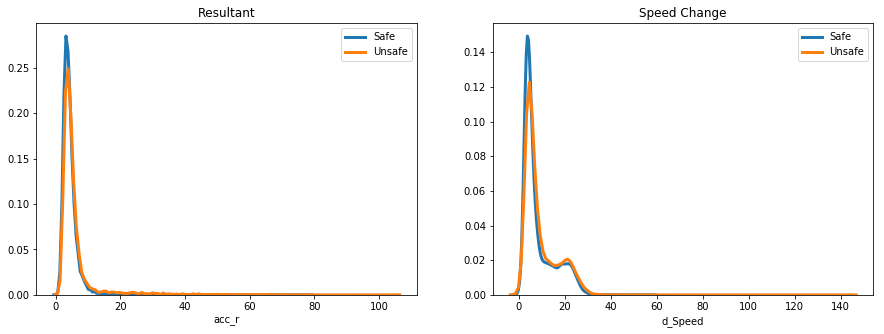

In [24]:
plotSafetyDist2Obs(max_trip_acc_labeled,"acc_r","d_Speed", "Resultant", "Speed Change")

By a slight but detailed observation, we see that the unsafe driving is more unlikely to happen in lower acceleration/speed change. However, it is a little hard to see the difference between safe/unsafe driving by these observations alone.

WAIT! It is also possible to have unsafe driving by high speed alone. Let's check. Other than the speed alone, we can compute the speed from the accelerometer (by integration, don't worry, it is simple).

$v_t (acc) =  \frac{\Delta t}{2} (acc_{r,t} + acc_{r,t-1})$

In [25]:
#integrating the acceleration for each time step, duplicates and appends a 0 value
series_acc1 = df['acc_r'].append(pd.Series([0]), ignore_index=True)
series_acc2 = pd.Series([0]).append(df['acc_r'], ignore_index=True)

#Setting the beginning of the trip is always 0
bookingID_beg1 = bookingID_beg.append(pd.Series([True]), ignore_index=True)
series_acc2[bookingID_beg1] = 0

#Computing the integration
df['i_acc'] = ((series_acc1 + series_acc2)/2)[:-1]


In [26]:
df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,acc_r,d_Speed,i_acc
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991,0.376551,0.000000,0.188275
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454,0.259553,3.214536,0.318052
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,0.296238,0.000000,0.277895
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,0.030320,0.000000,0.163279
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454,0.167466,0.000000,0.098893


Again, we use the MAX as the aggregation for the to check the highest speed in a single trip.

In [27]:
max_trip_speed = df[['bookingID','Speed','i_acc']].groupby(['bookingID'], as_index=False).max()
max_trip_speed_labeled = pd.merge(max_trip_speed,label,on="bookingID")

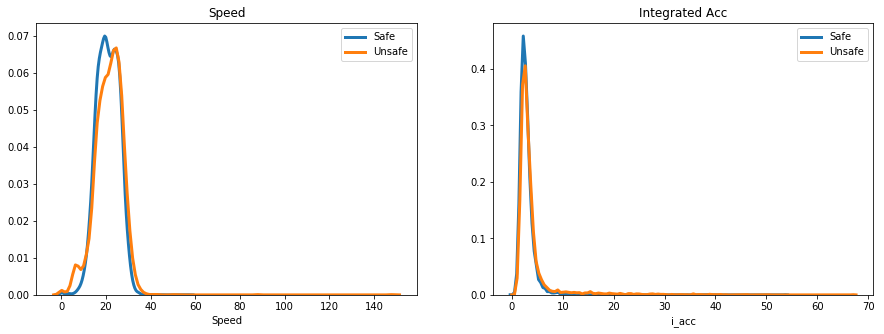

In [28]:
plotSafetyDist2Obs(max_trip_speed_labeled,"Speed","i_acc", "Speed", "Integrated Acc")

From the GPS speed only, we can distinguish the difference between safe and unsafe driving better visually. However, we see that the unsafe driving tends to be higher in some lower range of speed. Thus, the speed might give us better insight to determine a safe/unsafe driving.

Next, let's check a different measure: orientation/angle.

### Checking high orientation change

Similar to the accelerometer, the gyroscope measures the orientation change in 3-axis. Thus, we would like to use its resultant by.

$\omega_r = \sqrt{\omega_x^2+\omega_y^2+\omega_z^2}$


In [29]:
df['gyro_r'] = np.sqrt(np.power(df['gyro_x'],2)
                      +np.power(df['gyro_y'],2)
                      +np.power(df['gyro_z'],2))

Then, we compute the change of the orientation from the GPS of each time step in a trip by the GPS Bearing variable.

In [30]:
#Computing the change is similar to the speed change, **TO BE REFACTORED INTO FUNCTION
series_orie1 = df['Bearing'].append(pd.Series([0]), ignore_index=True)
series_orie2 = pd.Series([0]).append(df['Bearing'], ignore_index=True)
df['d_Bearing'] = (series_orie1 - series_orie2)[:-1]

#marking the beginning of the trip
df.loc[bookingID_beg,'d_Bearing'] = 0

#Negative change is equal to the positive change in degree
df['d_Bearing'] = np.abs(df['d_Bearing'])

#The bearing change >180 must be re-computed as the angle change > 180 is equal to angle change <=180.
## This is caused by [0...360] range
df.loc[df['d_Bearing']>180,'d_Bearing'] = 360 - df.loc[df['d_Bearing']>180,'d_Bearing']

In [31]:
df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,acc_r,d_Speed,i_acc,gyro_r,d_Bearing
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991,0.376551,0.000000,0.188275,0.118788,0.0
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454,0.259553,3.214536,0.318052,0.101508,0.0
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,0.296238,0.000000,0.277895,0.046282,0.0
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,0.030320,0.000000,0.163279,0.034511,0.0
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454,0.167466,0.000000,0.098893,0.053095,0.0


Hmmm... many zeroes? Let's check by the distribution, again using MAX aggregation for each trip.

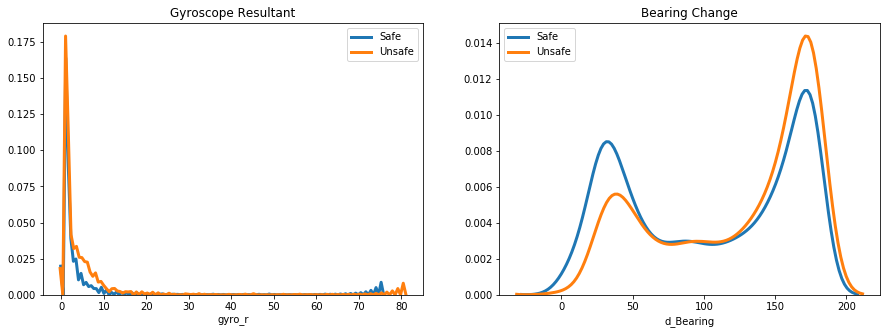

In [32]:
max_trip_orie = df[['bookingID','gyro_r','d_Bearing']].groupby(['bookingID'], as_index=False).max()
max_trip_orie_labeled = pd.merge(max_trip_orie,label,on="bookingID")
plotSafetyDist2Obs(max_trip_orie_labeled,"gyro_r","d_Bearing", "Gyroscope Resultant", "Bearing Change")

Hmm, there's still weird data. Even though we see that higher bearing change tends to lead an unsafe driving, it is possible that GPS has an error/noise that we should take care of. We will check whether high bearing change can be happened because of noise or not.

1. Check possible noisy trip as sample
2. Show the plot of the sampled trips based on booking IDs

In [33]:
df.loc[df['d_Bearing']>170,['bookingID','Bearing','second','d_Bearing']].head(10)

,bookingID,Bearing,second,d_Bearing
7231,13,0.0,1101.0,175.0
8064,16,223.0,62.0,178.0
8306,16,0.0,307.0,177.0
8369,16,177.0,371.0,177.0
8811,17,0.0,157.0,175.0
8814,17,175.0,160.0,175.0
8816,17,0.0,162.0,175.0
8827,17,173.0,173.0,173.0
14985,29,226.0,1154.0,177.0
15068,30,0.0,68.0,177.0


In [34]:
df.loc[df['d_Bearing']>170,['bookingID','Bearing','second','d_Bearing']].tail(10)

,bookingID,Bearing,second,d_Bearing
16131110,1709396983947,125.0,795.0,172.0
16131123,1709396983947,0.0,808.0,177.0
16131124,1709396983947,177.0,809.0,177.0
16131125,1709396983947,0.0,810.0,177.0
16131127,1709396983947,177.0,812.0,177.0
16131136,1709396983947,0.0,822.0,177.0
16131457,1709396983948,109.0,183.0,179.0
16131459,1709396983948,280.0,185.0,171.0
16131564,1709396983957,96.0,29.0,178.0
16132512,1709396983957,285.0,1035.0,179.0


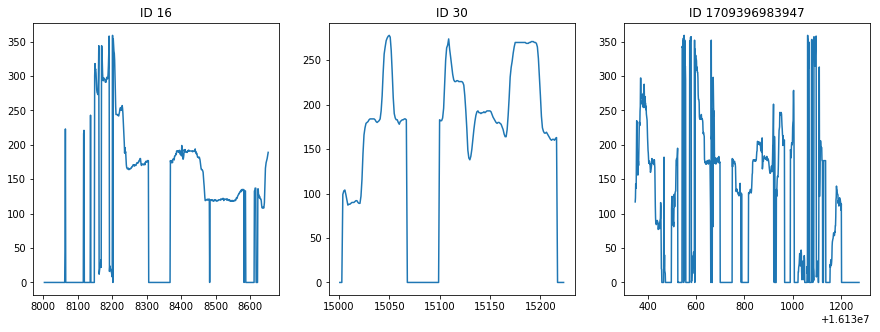

In [35]:
#We will check bookingID 16, 30, & 1709396983947
bookIdSample = [16,30,1709396983947]

fig = plt.figure(figsize=(15,5))


for i in range(len(bookIdSample)):
    ax = fig.add_subplot(1,3,i+1)
    ax.title.set_text("ID "+str(bookIdSample[i]))
    df.loc[df["bookingID"]==bookIdSample[i],'Bearing'].plot()

plt.show()

Yep, most likely they are noisy. We claim its noise by the sudden jump from low to high value or vice versa. While the trip 30 is not very noisy, the other sampled trips suffer from this issue. Note that also in the middle of the trip, trip 30 misses some observation on the GPS(!). Thus, it is important to preprocess the data either for GPS or the accelerometer/gyroscope.

Why do not we conclude this finding on the accelerometer/speed GPS/Gyroscope data? Because:

1. GPS position is not provided in dataset
2. The speed (as distance change) is more likely to be in smaller range and unbounded than the bearing (orientation). Hence, the noisy/missing data can be easily noticed in the bearing.

Let's what happened on check trip 30's missing data (around index 15060-15110), maybe GPS' accuracy has something to do with it

In [36]:
df[15060:15110][['Accuracy','Bearing','Speed','gyro_r','acc_r']]

,Accuracy,Bearing,Speed,gyro_r,acc_r
15060,4.093,178.0,2.98,0.064721,0.061569
15061,3.648,181.0,1.15,0.012676,0.115256
15062,3.358,182.0,0.47,0.015103,0.298097
15063,3.249,183.0,0.94,0.016973,0.389759
15064,3.284,183.0,1.42,0.013614,0.346872
15065,3.314,184.0,1.47,0.052776,0.259003
15066,3.290,184.0,1.29,0.021568,0.483707
15067,3.156,183.0,0.53,0.011734,0.362856
15068,3.045,0.0,0.00,0.003716,0.470523
15069,3.000,0.0,0.00,0.007485,0.359978


As claimed before, by the speed only, it is not very clear that the GPS suffers from missing data. The speed gradually changes in the small range and unnoticably if the Bearing data's missing.

#### **NOTE: might be better to use infinity value to redefine Missing Data**

## Let's try to classify! (Without Preprocessing)

Using the features available (except: bookingID, seconds), and the derived ones, such as acc_r, d_Speed, i_acc, and gyro_r. We will build aggregated features to check the quality of the classification. **NOTE THAT** the aggregation is likely impractical to be used in real-time inference.

In [37]:
df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,acc_r,d_Speed,i_acc,gyro_r,d_Bearing
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991,0.376551,0.000000,0.188275,0.118788,0.0
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454,0.259553,3.214536,0.318052,0.101508,0.0
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,0.296238,0.000000,0.277895,0.046282,0.0
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,0.030320,0.000000,0.163279,0.034511,0.0
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454,0.167466,0.000000,0.098893,0.053095,0.0


In [38]:
df_nosec = df.drop(columns=['second'])
df_agg_mean = df_nosec.groupby(['bookingID'], as_index=False).mean()
df_agg_max = df_nosec.groupby(['bookingID'], as_index=False).max()
df_agg_min = df_nosec.groupby(['bookingID'], as_index=False).min()

col_mean = ['bookingID']
col_max = ['bookingID']
col_min = ['bookingID']
colnames_default = df_nosec.columns
for colname in colnames_default:
    if colname=='bookingID':
        continue
    col_mean.append(colname+"_mean")
    col_max.append(colname+"_max")
    col_min.append(colname+"_min")

df_agg_mean.columns = col_mean
df_agg_max.columns = col_max
df_agg_min.columns = col_min

df_agg = pd.merge(df_agg_mean,df_agg_max,on="bookingID")
df_agg = pd.merge(df_agg,df_agg_min,on="bookingID")

In [39]:
df_agg.columns

Index(['bookingID', 'Accuracy_mean', 'Bearing_mean', 'acceleration_x_mean',
       'acceleration_y_mean', 'acceleration_z_mean', 'gyro_x_mean',
       'gyro_y_mean', 'gyro_z_mean', 'Speed_mean', 'acc_r_mean',
       'd_Speed_mean', 'i_acc_mean', 'gyro_r_mean', 'd_Bearing_mean',
       'Accuracy_max', 'Bearing_max', 'acceleration_x_max',
       'acceleration_y_max', 'acceleration_z_max', 'gyro_x_max', 'gyro_y_max',
       'gyro_z_max', 'Speed_max', 'acc_r_max', 'd_Speed_max', 'i_acc_max',
       'gyro_r_max', 'd_Bearing_max', 'Accuracy_min', 'Bearing_min',
       'acceleration_x_min', 'acceleration_y_min', 'acceleration_z_min',
       'gyro_x_min', 'gyro_y_min', 'gyro_z_min', 'Speed_min', 'acc_r_min',
       'd_Speed_min', 'i_acc_min', 'gyro_r_min', 'd_Bearing_min'],
      dtype='object')

In [40]:
df_agg.head()

,bookingID,Accuracy_mean,Bearing_mean,acceleration_x_mean,acceleration_y_mean,acceleration_z_mean,gyro_x_mean,gyro_y_mean,gyro_z_mean,Speed_mean,...,acceleration_z_min,gyro_x_min,gyro_y_min,gyro_z_min,Speed_min,acc_r_min,d_Speed_min,i_acc_min,gyro_r_min,d_Bearing_min
0,0,10.165339,176.526099,-0.711264,-9.613822,-1.619658,0.003328,-0.006118,-0.004188,8.995818,...,-6.251807,-0.392537,-0.609930,-0.731892,0.0,0.000428,0.0,0.014246,0.003067,0.0
1,1,3.718763,124.198590,-0.525406,9.532086,-2.198999,-0.002467,-0.007540,0.000405,7.896864,...,-5.355455,-0.125367,-0.678183,-0.121265,0.0,0.000197,0.0,0.005206,0.000509,0.0
2,2,3.930626,173.794872,0.306786,9.843183,0.139347,0.006458,-0.012861,0.002597,3.157213,...,-3.282551,-0.155218,-0.462000,-0.125907,0.0,0.001377,0.0,0.016796,0.003169,0.0
3,4,10.000000,151.807013,-0.365117,-9.406439,-2.613639,-0.022884,0.023232,-0.000376,6.150996,...,-9.374869,-0.420507,-0.506531,-0.348189,0.0,0.000427,0.0,0.004430,0.007985,0.0
4,6,4.586721,197.812785,0.490616,9.538043,2.355059,0.003877,0.000436,0.002930,4.628921,...,-2.140482,-0.253551,-0.621802,-0.348345,0.0,0.000974,0.0,0.010101,0.002113,0.0


In [43]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


In [45]:
def kfoldValidation(df_train, label, model, k):
    
    #just in case someone forgots
    if "bookingID" in df_train.columns:
        df_train = df_train.drop(columns=['bookingID'])
    
    sum_acc = 0
    sum_auc = 0
    kf = KFold(n_splits=k)
    
    for train, val in kf.split(df_train):
        train_data = np.array(df_train)[train]
        train_label = np.array(label)[train]
        val_data = np.array(df_train)[val]
        val_label = np.array(label)[val]
        
        model.fit(train_data,train_label)

        val_pred  = model.predict_proba(val_data)[:,1]

        sum_acc = sum_acc + accuracy_score(val_label, 1 * (val_pred >0.5) )
        sum_auc = sum_auc + roc_auc_score(val_label, val_pred)

    return sum_acc/k, sum_auc/k

In [46]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=4,random_state=0)
kfoldValidation(df_agg,labelc["label"],rf_clf,10)

(0.7649000000000001, 0.6630623328472272)

In [48]:
xgb_clf = XGBClassifier(n_jobs=-1)
kfoldValidation(df_agg,labelc["label"],xgb_clf,10)

(0.76705, 0.6863923253025904)

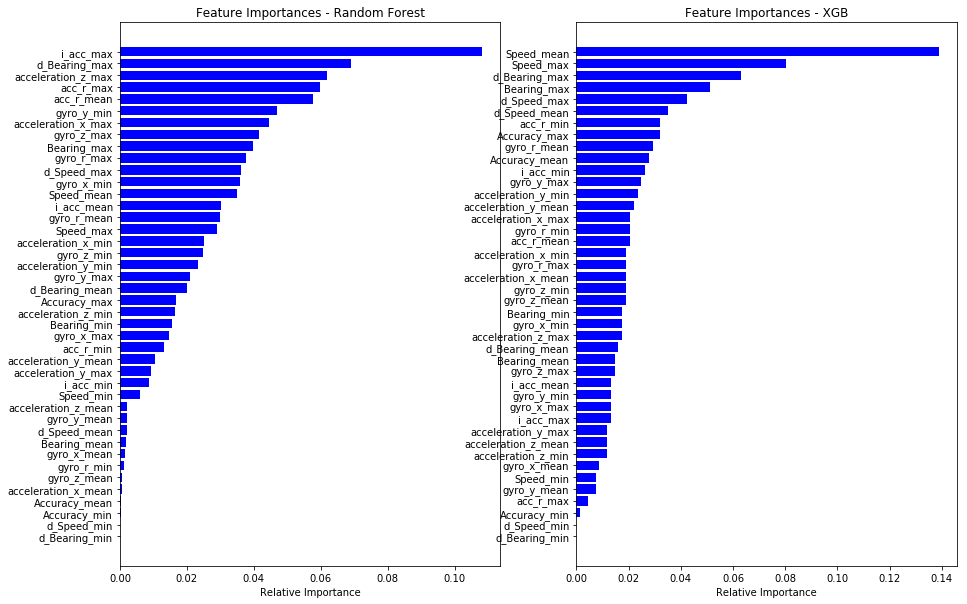

In [98]:
df_train = df_agg.drop(columns=['bookingID'])

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=3,random_state=0)
rf_clf.fit(df_train,labelc["label"])

xgb_clf = XGBClassifier(n_jobs=-1)
xgb_clf.fit(df_train,labelc["label"])

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
plotFeatureImportance(rf_clf,ax,df_train.columns,"Random Forest")
ax = fig.add_subplot(1,2,2)
plotFeatureImportance(xgb_clf,ax,df_train.columns,"XGB")

plt.show()

In [97]:
def plotFeatureImportance(clf, ax, columnNames, strModelName):
    indices = np.argsort(clf.feature_importances_)
    ax.title.set_text('Feature Importances - '+strModelName)
    ax.barh(range(len(indices)), clf.feature_importances_[indices], color='b', align='center')
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([columnNames[i] for i in indices])
    ax.set_xlabel('Relative Importance')

Let's try to smooth the sensors' data using a simple moving window average method. Let's say a raw sensor value $x_t$ at time $t$ and we want to smooth it as $\bar{x}_t$. We will assign a smoothed value $\bar{x}_t$ as the average of its raw value and $l-1$ previous raw values. However, we will only use available data for the first $l-1$ values.

$\bar{x}_t = \frac{1}{l} \sum_{i=0}^{l-1} x_{t-i}$

Example: Bearing value at t=0 until t=3: \{ 300, 320, 0, 20\} and $l=3$, we will get the smoothed values:

$\bar{x}_0 = \frac{1}{3}(0+0+300) = 100$

$\bar{x}_1 = \frac{1}{3}(0+300+320) = 313.33$

$\bar{x}_2 = \frac{1}{3}(300+320+0) = 206.66$

$\bar{x}_3 = \frac{1}{3}(320+0+20) = 106.66$

Wait something's wrong for t=2 and t=3, shouldn't it be closer to $\approx$ 360-ish? Well, this is a well known problem of averaging degrees, we will use [Mean Angle](https://rosettacode.org/wiki/Averages/Mean_angle) --> Only applies to Bearing, other sensors are safe!

$\bar{x}_t = atan2(\frac{1}{l}.\sum_{i=0}^{l-1} sin(x_{t-i}),\frac{1}{l}.\sum_{i=0}^{l-1} cos(x_{t-i}))$

Much better! Let's define the function!

**Note**: Unlike the Bearings, we can apply this moving window average simply to the other sensors. We define this as a new function smoothMWA.


In [247]:
def smoothMWA(rows,tripBegin, isBearing=False, l=3):
    a=1*~tripBegin
    shift = rows
    for i in range(l-1):
        shift = pd.Series([0]).append(shift, ignore_index=True)[:-1] 
        rows = pd.concat([rows,(a*shift)],axis=1)
        a = a * pd.Series([0]).append(a, ignore_index=True)[:-1] 

    if isBearing:
        rows = rows - 180
        rows = np.radians(rows)
        sina = np.sin(rows).mean(axis=1)
        cosa = np.cos(rows).mean(axis=1)
        rows = np.degrees(np.arctan2(sina,cosa))
        return rows
    else:
        return (rows/l).sum(axis=1)

In [182]:
sdf.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,0,12.0,14.329829,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991
1,0,8.0,28.659659,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454
2,0,8.0,42.989488,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454
3,0,8.0,57.319318,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454
4,0,8.0,71.649147,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454


In [176]:
df.columns


Index(['bookingID', 'Accuracy', 'Bearing', 'acceleration_x', 'acceleration_y',
       'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z', 'second', 'Speed'],
      dtype='object')

In [248]:
#smoothingColumns = ['Bearing', 'acceleration_x', 'acceleration_y',
       #'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z','Speed']
smoothingColumns = ['Bearing']
    
sdf = df[['bookingID','Accuracy','second']]
for column in smoothingColumns:
    if column=='Bearing':
        sdf[column] = smoothMWA(df[column],bookingID_beg,True,l=3)
    else:
        sdf[column] = smoothMWA(df[column],bookingID_beg,l=3)


D:\Env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


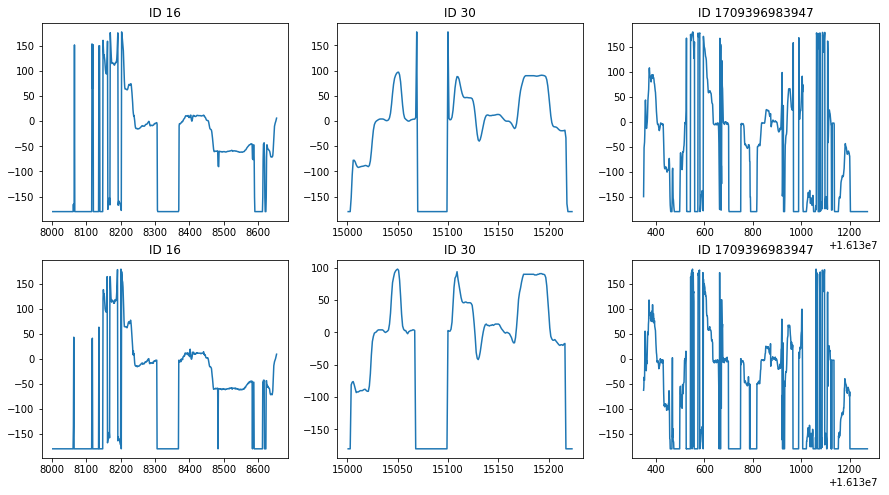

In [249]:
#We will check bookingID 16, 30, & 1709396983947
bookIdSample = [16,30,1709396983947]

fig = plt.figure(figsize=(15,8))


for i in range(len(bookIdSample)):
    ax = fig.add_subplot(2,3,i+1)
    ax.title.set_text("ID "+str(bookIdSample[i]))
    (sdf.loc[sdf["bookingID"]==bookIdSample[i],'Bearing']).plot()
    ax = fig.add_subplot(2,3,3+i+1)
    ax.title.set_text("ID "+str(bookIdSample[i]))
    (df.loc[df["bookingID"]==bookIdSample[i],'Bearing']-180).plot()

plt.show()

In [239]:
df[8000:8010]-180

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
8000,-166,-148.000,40.164856,-180.127853,-189.793869,-179.119980,-180.114193,-180.072861,-180.023766,417.0,-159.728304
8001,-166,-148.000,40.164856,-180.216080,-189.936826,-179.343387,-179.912197,-180.016840,-179.943834,418.0,-159.219965
8002,-166,-148.000,40.164856,-180.004785,-190.227225,-179.164990,-180.047610,-179.979346,-180.025936,419.0,-159.219965
8003,-164,-172.650,-180.000000,-179.032743,-170.423193,-179.694739,-179.991032,-179.992535,-180.002602,-180.0,-180.000000
8004,-164,-172.677,-180.000000,-178.977676,-170.332213,-179.771354,-179.996530,-179.998033,-180.012987,-179.0,-180.000000
8005,-164,-172.696,-180.000000,-179.121328,-170.426784,-179.632490,-179.999585,-180.013916,-180.017263,-178.0,-180.000000
8006,-164,-172.710,-180.000000,-179.027954,-170.376506,-179.713893,-179.997752,-180.002920,-180.016041,-177.0,-180.000000
8007,-164,-172.720,-180.000000,-179.206322,-170.298695,-179.608548,-179.994087,-180.005363,-180.008100,-176.0,-180.000000
8008,-164,-172.728,-180.000000,-179.060276,-170.331017,-179.689951,-179.998974,-180.000476,-180.016652,-175.0,-180.000000
8009,-164,-172.733,-180.000000,-179.124919,-170.450727,-179.626505,-179.998974,-180.013305,-180.016041,-174.0,-180.000000


In [241]:
sdf[8000:8010]

,bookingID,Accuracy,second,Bearing
8000,14,32.000,597.0,141.276731
8001,14,32.000,598.0,141.276731
8002,14,32.000,599.0,141.276731
8003,16,7.350,0.0,126.759688
8004,16,7.323,1.0,126.759688
8005,16,7.304,2.0,126.759688
8006,16,7.290,3.0,126.759688
8007,16,7.280,4.0,126.759688
8008,16,7.272,5.0,126.759688
8009,16,7.267,6.0,126.759688


In [124]:
print(add360XOR.values.reshape((len(add360XOR),1)).shape)
print(add360.sum().sum())
print((add360XOR.values.reshape((len(add360XOR),1)) * add360.values).sum().sum())

(16135561, 1)
25722743
26975


In [246]:
rows = np.array([[0,0,0],[0,0,0],[0,0,0],[220.164,220.164,220.164]])
rows = rows - 180
sina = np.sin(rows).mean(axis=1)
cosa = np.cos(rows).mean(axis=1)
rows = np.degrees(np.arctan2(cosa,sina))
rows

array([-36.75968765, -36.75968765, -36.75968765, -51.22768836])

In [223]:
sina

array([-2.77555756e-17,  8.13797681e-01,  2.57834160e-01,  0.00000000e+00])

In [224]:
cosa

array([ 9.84807753e-01,  4.69846310e-01,  9.62250187e-01, -6.12323400e-17])